In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_beit_model(num_classes=4, pretrained=True):
    """
    Create BEiT v2 (Bidirectional Encoder representation from Image Transformers) model
    
    Args:
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: BEiT v2 Base model
    """
    model = timm.create_model('beitv2_base_patch16_224', pretrained=pretrained, num_classes=num_classes)
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train BEiT v2 Base

Training BEiT-V2-Base


model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:25<00:00,  1.51it/s, Loss=1.3995, Acc=0.2706]


Train Loss: 1.3995 Acc: 0.2706 Macro-F1: 0.2555


Val : 100%|██████████| 10/10 [00:02<00:00,  3.43it/s, Loss=1.2722, Acc=0.4309]


Val Loss: 1.2722 Acc: 0.4309 Macro-F1: 0.2600
✓ New best model saved with validation macro-F1: 0.2600

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.3418, Acc=0.3569]


Train Loss: 1.3418 Acc: 0.3569 Macro-F1: 0.3152


Val : 100%|██████████| 10/10 [00:02<00:00,  4.46it/s, Loss=1.2858, Acc=0.3980]


Val Loss: 1.2858 Acc: 0.3980 Macro-F1: 0.2501

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.2969, Acc=0.4515]


Train Loss: 1.2969 Acc: 0.4515 Macro-F1: 0.3620


Val : 100%|██████████| 10/10 [00:02<00:00,  4.32it/s, Loss=1.2766, Acc=0.4178]


Val Loss: 1.2766 Acc: 0.4178 Macro-F1: 0.3133
✓ New best model saved with validation macro-F1: 0.3133

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.59it/s, Loss=1.2373, Acc=0.4613]


Train Loss: 1.2373 Acc: 0.4613 Macro-F1: 0.4092


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=1.1774, Acc=0.4671]


Val Loss: 1.1774 Acc: 0.4671 Macro-F1: 0.3837
✓ New best model saved with validation macro-F1: 0.3837

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=1.1921, Acc=0.4482]


Train Loss: 1.1921 Acc: 0.4482 Macro-F1: 0.4135


Val : 100%|██████████| 10/10 [00:02<00:00,  4.35it/s, Loss=1.2013, Acc=0.4178]


Val Loss: 1.2013 Acc: 0.4178 Macro-F1: 0.3451

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=1.2177, Acc=0.4564]


Train Loss: 1.2177 Acc: 0.4564 Macro-F1: 0.4153


Val : 100%|██████████| 10/10 [00:02<00:00,  4.27it/s, Loss=1.1757, Acc=0.4770]


Val Loss: 1.1757 Acc: 0.4770 Macro-F1: 0.3991
✓ New best model saved with validation macro-F1: 0.3991

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=1.1900, Acc=0.4285]


Train Loss: 1.1900 Acc: 0.4285 Macro-F1: 0.4019


Val : 100%|██████████| 10/10 [00:02<00:00,  4.33it/s, Loss=1.0513, Acc=0.5164]


Val Loss: 1.0513 Acc: 0.5164 Macro-F1: 0.4553
✓ New best model saved with validation macro-F1: 0.4553

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.57it/s, Loss=1.0861, Acc=0.4745]


Train Loss: 1.0861 Acc: 0.4745 Macro-F1: 0.4268


Val : 100%|██████████| 10/10 [00:02<00:00,  4.32it/s, Loss=1.0073, Acc=0.5230]


Val Loss: 1.0073 Acc: 0.5230 Macro-F1: 0.4791
✓ New best model saved with validation macro-F1: 0.4791

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=1.0540, Acc=0.5715]


Train Loss: 1.0540 Acc: 0.5715 Macro-F1: 0.5196


Val : 100%|██████████| 10/10 [00:02<00:00,  4.32it/s, Loss=0.9823, Acc=0.6020]


Val Loss: 0.9823 Acc: 0.6020 Macro-F1: 0.5638
✓ New best model saved with validation macro-F1: 0.5638

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=1.0475, Acc=0.5962]


Train Loss: 1.0475 Acc: 0.5962 Macro-F1: 0.5340


Val : 100%|██████████| 10/10 [00:02<00:00,  4.29it/s, Loss=0.9540, Acc=0.6086]


Val Loss: 0.9540 Acc: 0.6086 Macro-F1: 0.5621

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=0.9980, Acc=0.6192]


Train Loss: 0.9980 Acc: 0.6192 Macro-F1: 0.5647


Val : 100%|██████████| 10/10 [00:02<00:00,  4.32it/s, Loss=0.9407, Acc=0.6217]


Val Loss: 0.9407 Acc: 0.6217 Macro-F1: 0.5886
✓ New best model saved with validation macro-F1: 0.5886

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=1.0017, Acc=0.6184]


Train Loss: 1.0017 Acc: 0.6184 Macro-F1: 0.5673


Val : 100%|██████████| 10/10 [00:02<00:00,  4.30it/s, Loss=0.9360, Acc=0.6447]


Val Loss: 0.9360 Acc: 0.6447 Macro-F1: 0.5964
✓ New best model saved with validation macro-F1: 0.5964

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=0.9604, Acc=0.6373]


Train Loss: 0.9604 Acc: 0.6373 Macro-F1: 0.5880


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=0.9002, Acc=0.6645]


Val Loss: 0.9002 Acc: 0.6645 Macro-F1: 0.6199
✓ New best model saved with validation macro-F1: 0.6199

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=0.9498, Acc=0.6513]


Train Loss: 0.9498 Acc: 0.6513 Macro-F1: 0.5952


Val : 100%|██████████| 10/10 [00:02<00:00,  4.35it/s, Loss=0.8897, Acc=0.6645]


Val Loss: 0.8897 Acc: 0.6645 Macro-F1: 0.6297
✓ New best model saved with validation macro-F1: 0.6297

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=0.9033, Acc=0.6752]


Train Loss: 0.9033 Acc: 0.6752 Macro-F1: 0.6243


Val : 100%|██████████| 10/10 [00:02<00:00,  4.38it/s, Loss=0.8902, Acc=0.6382]


Val Loss: 0.8902 Acc: 0.6382 Macro-F1: 0.6063

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=0.8777, Acc=0.6702]


Train Loss: 0.8777 Acc: 0.6702 Macro-F1: 0.6230


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=0.8796, Acc=0.6382]


Val Loss: 0.8796 Acc: 0.6382 Macro-F1: 0.6061

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=0.8575, Acc=0.6883]


Train Loss: 0.8575 Acc: 0.6883 Macro-F1: 0.6300


Val : 100%|██████████| 10/10 [00:02<00:00,  4.31it/s, Loss=0.8732, Acc=0.6382]


Val Loss: 0.8732 Acc: 0.6382 Macro-F1: 0.6071

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=0.8690, Acc=0.6867]


Train Loss: 0.8690 Acc: 0.6867 Macro-F1: 0.6380


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=0.8792, Acc=0.6349]


Val Loss: 0.8792 Acc: 0.6349 Macro-F1: 0.5988

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.57it/s, Loss=0.8444, Acc=0.6941]


Train Loss: 0.8444 Acc: 0.6941 Macro-F1: 0.6461


Val : 100%|██████████| 10/10 [00:02<00:00,  4.29it/s, Loss=0.8831, Acc=0.6316]


Val Loss: 0.8831 Acc: 0.6316 Macro-F1: 0.5970
Early stopping triggered after 19 epochs
Training complete in 8m 30s
Best validation macro-F1: 0.6297


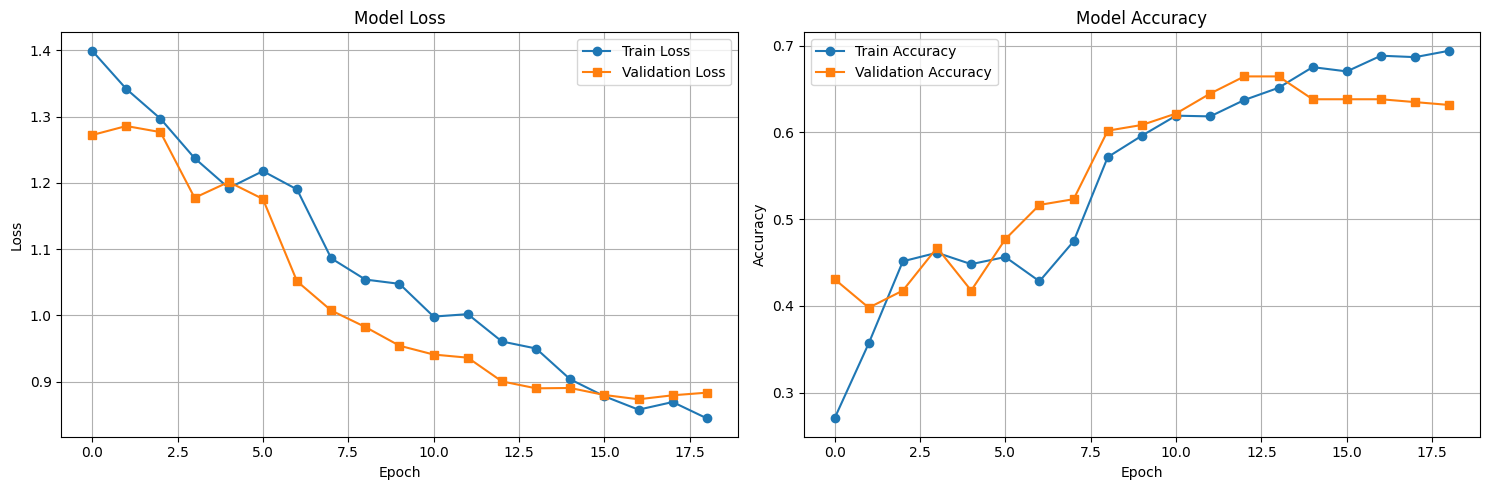

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Test Accuracy: 39.68%
Test Loss: 1.3840

Classification Report:
              precision    recall  f1-score   support

         HGC       0.59      0.36      0.45        74
         LGC       0.34      0.21      0.26        53
         NST       0.50      0.78      0.61        37
         NTL       0.15      0.32      0.21        25

    accuracy                           0.40       189
   macro avg       0.40      0.42      0.38       189
weighted avg       0.44      0.40      0.40       189


Confusion Matrix:
[[27 11 23 13]
 [17 11  0 25]
 [ 0  1 29  7]
 [ 2  9  6  8]]

ROC-AUC Scores:
Macro-average AUC: 0.7097
Micro-average AUC: 0.6942
HGC AUC: 0.6577
LGC AUC: 0.7395
NST AUC: 0.8711
NTL AUC: 0.5705


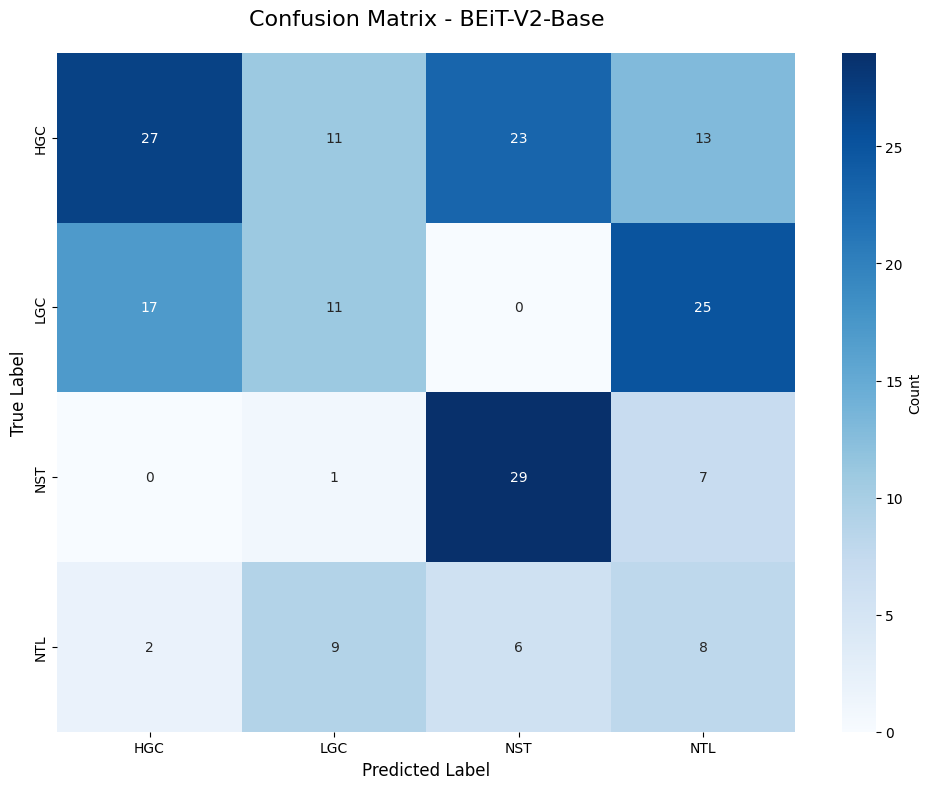

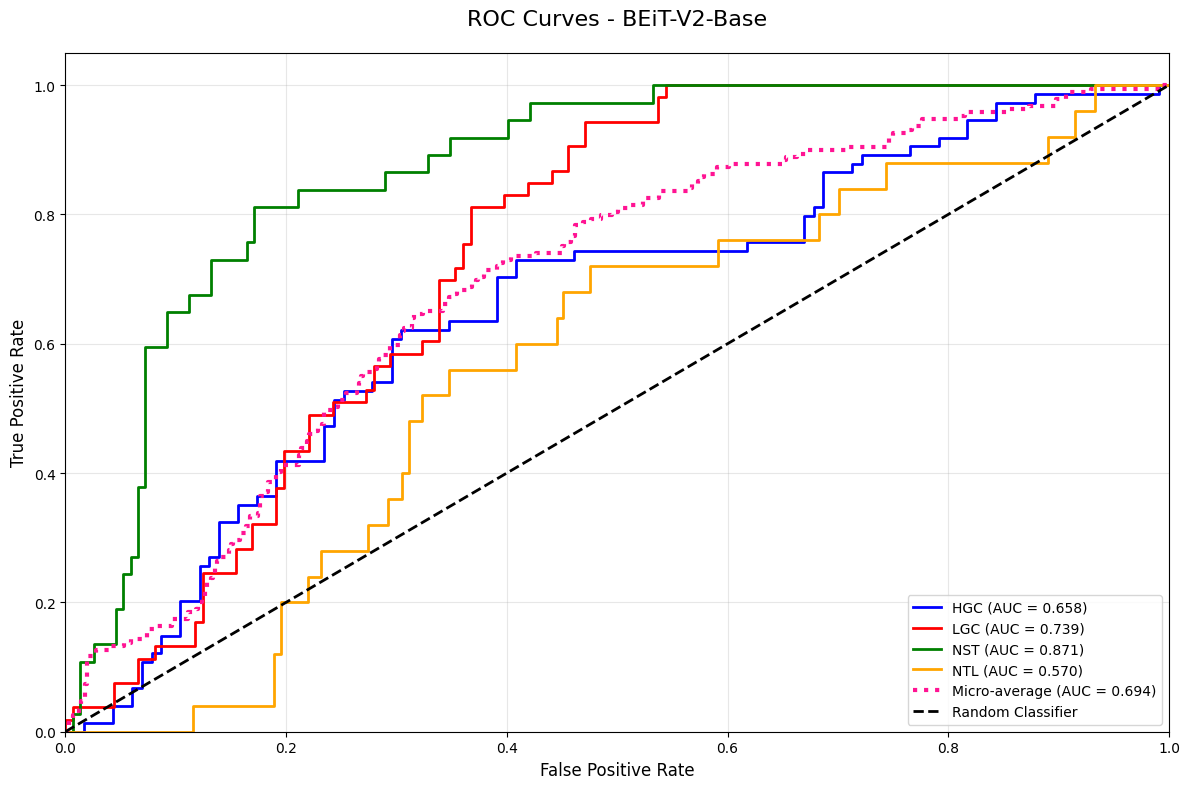


BEiT-V2-Base training and evaluation complete!


In [16]:
print("=" * 80)
print("Training BEiT-V2-Base")
print("=" * 80)

# Create model
beit_base = create_beit_model(num_classes=4, pretrained=True)

# Create trainer
trainer_beit_base = ModelTrainer(beit_base, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_beit_base = trainer_beit_base.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="BEiT-V2-Base")

# Plot training history
trainer_beit_base.plot_training_history(save_path='beit_v2_base_training_history.png')

# Evaluate model
results_beit_base = trainer_beit_base.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_beit_base['confusion_matrix'], class_names, 'BEiT-V2-Base',
                      save_path='beit_v2_base_confusion_matrix.png')

# Plot ROC curves
roc_auc_beit_base = plot_roc_curves(results_beit_base['labels'], results_beit_base['probabilities'], class_names, 'BEiT-V2-Base',
                                     save_path='beit_v2_base_roc_curves.png')

# Store results
results_beit_base['model_name'] = 'BEiT-V2-Base'
results_beit_base['roc_auc'] = roc_auc_beit_base
all_results.append(results_beit_base)

print("\nBEiT-V2-Base training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'BEiT_V2_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: BEiT_V2_metrics.csv

Metrics Summary:
          Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall  HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  BEiT-V2-Base          39.68254      1.383995             0.395412          0.419049       0.38112                0.444059             0.396825         0.395425       0.586957    0.364865    0.45         74.0        0.34375    0.207547  0.258824         53.0            0.5    0.783784  0.610526         37.0       0.150943        0.32  0.205128         25.0   0.709682   0.694241  0.657697  0.739456  0.871088  0.570488      0.657697      0.